In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
import numpy as np
import math
from copy import deepcopy

<center>Moran 2011 - <br/> Modeling the Healthy and Parkinsonian Cortico-Basal Ganglia-Thalamocortical Circuit
--------------------------------------------------------------------------------------------------------------
</center>

<img src="img/Moran_2011_F1.png",width=600,height=600>

**A:** Model architecture
**B:** LFP recordings from healthy / parkinsonian rats

<br/>

**<center>Neural Mass Model Set-Up</center>**

<img src="img/Moran_2011_F2.png",width=600,height=600>

**<center>BGTC model fitted on healthy vs parkinsonian LFP data</center>**

<img src="img/Moran_2011_F3.png",width=600,height=600>

**A:** Spectral powers of LFP data and BGTC model simulations
**B:** Fitted BGTC connectivity parameters

Rebuild above described BGTC model with PyRates
------------------------------------------------------

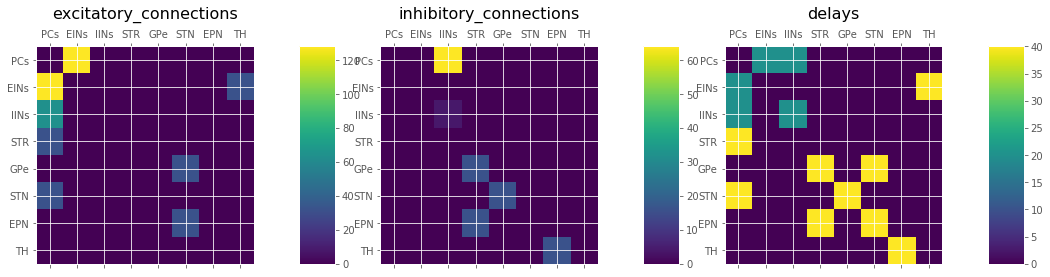

In [53]:
from core.population import MoranPyramidalCells, MoranExcitatoryInterneurons, MoranInhibitoryInterneurons

#####################
# BGTC model set-up #
#####################

# parametrization
#################

# general parameters
step_size = 1e-4
max_synaptic_delay = 1.0
n_populations = 8
n_synapses = 2
pop_names = ['PCs', 'EINs', 'IINs', 'STR', 'GPe', 'STN', 'EPN', 'TH']

# synaptic parameters
synapse_params_excitatory = {'efficacy': 8e-3, 'tau': 4e-3}
synapse_params_inhibitory = {'efficacy': -32e-3, 'tau': 16e-3}

# connectivity
excitatory_conn_strength = 32
inhibitory_conn_strength = 16
excitatory_conns = [[0, 3], [0, 5], [5, 4], [5, 6], [7, 1]]
inhibitory_conns = [[3, 4], [3, 6], [4, 5], [6, 7]]

connectivity = np.zeros((n_populations, n_populations, n_synapses))
connectivity[1, 0, 0] = 128
connectivity[2, 0, 0] = 64
connectivity[0, 1, 0] = 128
connectivity[0, 2, 1] = 64
connectivity[2, 2, 1] = 4

for c_e in excitatory_conns:
    connectivity[c_e[1], c_e[0], 0] = excitatory_conn_strength
    
for c_i in inhibitory_conns:
    connectivity[c_i[1], c_i[0], 1] = inhibitory_conn_strength

# delays 
intrinsic_delay = int(2e-3 / step_size)
extrinsic_delay = int(4e-3 / step_size)
delays = np.zeros((n_populations, n_populations))
delays_tmp = np.zeros((3, 3))
delays_tmp[connectivity[0:3, 0:3, 0] > 0] = intrinsic_delay 
delays_tmp[connectivity[0:3, 0:3, 1] > 0] = intrinsic_delay 
delays[0:3, 0:3] = delays_tmp

for c_e in excitatory_conns:
    delays[c_e[1], c_e[0]] = extrinsic_delay
for c_i in inhibitory_conns:
    delays[c_i[1], c_i[0]] = extrinsic_delay
    
# population initialization
###########################

# cortex
PCs = MoranPyramidalCells(step_size=step_size, 
                          max_synaptic_delay=max_synaptic_delay, 
                          synapse_params=[synapse_params_excitatory, synapse_params_inhibitory],
                          label=pop_names[0])

EINs = MoranExcitatoryInterneurons(step_size=step_size,
                                   max_synaptic_delay=max_synaptic_delay,
                                   synapse_params=[synapse_params_excitatory],
                                   label=pop_names[1])

IINs = MoranInhibitoryInterneurons(step_size=step_size,
                                   max_synaptic_delay=max_synaptic_delay,
                                   synapse_params=[synapse_params_excitatory, synapse_params_inhibitory],
                                   label=pop_names[2])

# basal ganglia
STR = MoranExcitatoryInterneurons(step_size=step_size,
                                  max_synaptic_delay=max_synaptic_delay,
                                  synapse_params=[synapse_params_excitatory],
                                  label=pop_names[3])

GPe = MoranPyramidalCells(step_size=step_size, 
                          max_synaptic_delay=max_synaptic_delay, 
                          synapse_params=[synapse_params_excitatory, synapse_params_inhibitory],
                          label=pop_names[4])

STN = MoranPyramidalCells(step_size=step_size, 
                          max_synaptic_delay=max_synaptic_delay, 
                          synapse_params=[synapse_params_excitatory, synapse_params_inhibitory],
                          label=pop_names[5])

EPN = MoranPyramidalCells(step_size=step_size, 
                          max_synaptic_delay=max_synaptic_delay, 
                          synapse_params=[synapse_params_excitatory, synapse_params_inhibitory],
                          label=pop_names[6])

# thalamus
TH = MoranExcitatoryInterneurons(step_size=step_size,
                                 max_synaptic_delay=max_synaptic_delay,
                                 synapse_params=[synapse_params_excitatory],
                                 label=pop_names[7])

# plot model set-up
###################

# population names
fig, axes = plt.subplots(1, 6, figsize=(18, 4), 
                         gridspec_kw = {'width_ratios':[7, 1, 7, 1, 7, 1]})

# excitatory connections
m_e = axes[0].matshow(connectivity[:, :, 0])
axes[0].set_title('excitatory_connections', y=1.1)
axes[0].set_xticks(np.arange(0, 8))
axes[0].set_yticks(np.arange(0, 8))
axes[0].set_xticklabels(pop_names)
axes[0].set_yticklabels(pop_names)
fig.colorbar(m_e, cax=axes[1])

# inhibitory connections
m_i = axes[2].matshow(connectivity[:, :, 1])
axes[2].set_title('inhibitory_connections', y=1.1)
axes[2].set_xticks(np.arange(0, 8))
axes[2].set_yticks(np.arange(0, 8))
axes[2].set_xticklabels(pop_names)
axes[2].set_yticklabels(pop_names)
fig.colorbar(m_i, cax=axes[3])

# delays
m_d = axes[4].matshow(delays)
axes[4].set_title('delays', y=1.1)
axes[4].set_xticks(np.arange(0, 8))
axes[4].set_yticks(np.arange(0, 8))
axes[4].set_xticklabels(pop_names)
axes[4].set_yticklabels(pop_names)
fig.colorbar(m_d, cax=axes[5])

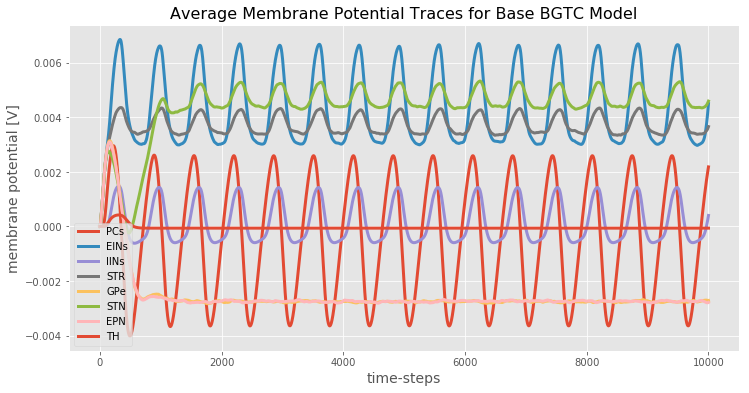

In [54]:
from core.circuit import Circuit

# BGTC model initialization
###########################

BGTC = Circuit(populations = [PCs, EINs, IINs, STR, GPe, STN, EPN, TH],
               connectivity = connectivity,
               delays = delays,
               step_size = step_size)

# simulation parameters
#######################

# general parameters
simulation_time = 1.
time_steps = int(simulation_time / step_size)

# input parameters
mean = 110.
var = 11.
input_targets = [1, 3, 4, 5, 6, 7]
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))
synaptic_input[:, input_targets, 0] = var * np.random.randn(time_steps, len(input_targets)) + mean

# simulate BGTC behavior
########################

# run
BGTC.run(synaptic_input, simulation_time)

# plot results
fig, axes = plt.subplots(figsize=(12,6))
axes = BGTC.plot_population_states(create_plot=False, axes=axes)
axes.set_title('Average Membrane Potential Traces for Base BGTC Model')

BGTC.clear()

Compare healthy vs Parkinsonian BGTC model
------------------------------------------------

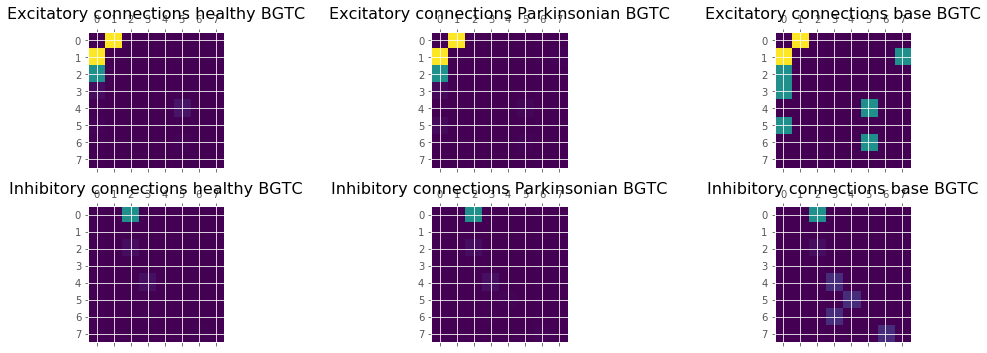

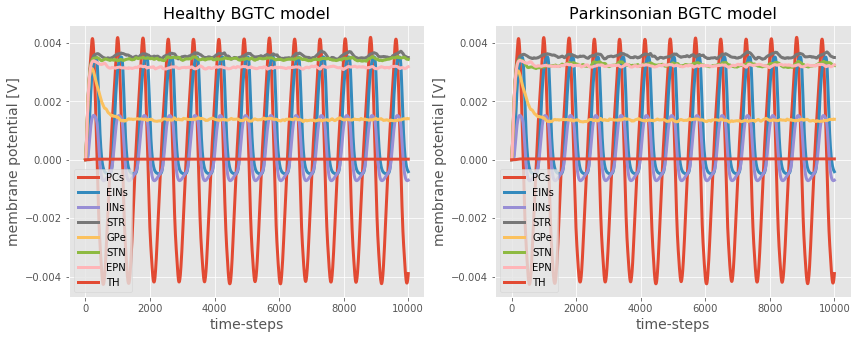

In [27]:
# parametrization
#################

# population list
populations_healthy = deepcopy(BGTC.populations)
populations_parkinson = deepcopy(BGTC.populations)
    
# connectivity matrices
connectivity_healthy = connectivity.copy()
connectivity_parkinson = connectivity.copy()

exc_conn_vals_healthy = [4.25, 1.44, 6.91, 1.43, 0.85]
inh_conn_vals_healthy = [5.24, 0.9, 0.29, 0.72]
exc_conn_vals_parkinson = [3.43, 3.07, 2.33, 1.18, 1.03]
inh_conn_vals_parkinson = [5.00, 0.74, 1.04, 1.03]

for i, c_e in enumerate(excitatory_conns):
    connectivity_healthy[c_e[1], c_e[0], 0] = exc_conn_vals_healthy[i]
    connectivity_parkinson[c_e[1], c_e[0], 0] = exc_conn_vals_parkinson[i]
for i, c_i in enumerate(inhibitory_conns):
    connectivity_healthy[c_i[1], c_i[0], 1] = inh_conn_vals_healthy[i]
    connectivity_parkinson[c_i[1], c_i[0], 1] = inh_conn_vals_parkinson[i]

# simulation parameters
simulation_time = 1.

# initialize healthy and parkinsonian model
###########################################

BGTC_healthy = Circuit(populations = populations_healthy,
                       connectivity = connectivity_healthy,
                       delays = delays,
                       step_size = step_size)

BGTC_parkinson = Circuit(populations = populations_parkinson,
                         connectivity = connectivity_parkinson,
                         delays = delays,
                         step_size = step_size)

# simulate healthy vs parkinsonian circuit behavior
###################################################

BGTC_healthy.run(synaptic_input, simulation_time)
BGTC_parkinson.run(synaptic_input, simulation_time)

# plot results
##############

# connectivities
fig, axes = plt.subplots(2, 3, figsize=(14,5))

axes[0, 0].matshow(connectivity_healthy[:, :, 0], clim=[0, 128])
axes[0, 0].set_title('Excitatory connections healthy BGTC')
axes[0, 1].matshow(connectivity_parkinson[:, :, 0], clim=[0, 128])
axes[0, 1].set_title('Excitatory connections Parkinsonian BGTC')
axes[0, 2].matshow(connectivity[:, :, 0], clim=[0, 128])
axes[0, 2].set_title('Excitatory connections base BGTC')

axes[1, 0].matshow(connectivity_healthy[:, :, 1], clim=[0, 128])
axes[1, 0].set_title('Inhibitory connections healthy BGTC')
axes[1, 1].matshow(connectivity_parkinson[:, :, 1], clim=[0, 128])
axes[1, 1].set_title('Inhibitory connections Parkinsonian BGTC')
axes[1, 2].matshow(connectivity[:, :, 1], clim=[0, 128])
axes[1, 2].set_title('Inhibitory connections base BGTC')

plt.tight_layout()

# membrane potentials
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0] = BGTC_healthy.plot_population_states(create_plot=False, axes=axes[0])
axes[0].set_title('Healthy BGTC model')
axes[1] = BGTC_parkinson.plot_population_states(create_plot=False, axes=axes[1])
axes[1].set_title('Parkinsonian BGTC model')